In [1]:
import sys
sys.path.append("../")
sys.path.append("../Modules/")

from Modules.simulation import Simulation
from Modules.cell_builder import SkeletonCell, CellBuilder
from Modules.constants import HayParameters

import os
from neuron import h

from logger import Logger # type: ignore

import numpy as np

--No graphics will be displayed.


In [2]:
%cd ../scripts

/home/drfrbc/Neural-Modeling/scripts


In [3]:
try:
    os.system("rm -r x86_64/")
except:
    pass

In [4]:
# initialize simulation object and parameters
sim = Simulation(SkeletonCell.Hay)
parameters = HayParameters(sim_name = 'AnalyticalRin', h_tstop= 1000, all_synapses_off=True) # NOTE: synapses will crash the simulation since they are not mapped and will remain on deleted sections

In [5]:
os.system(f"nrnivmodl {sim.cell_type.value['modfiles']} > /dev/null 2>&1")

h.load_file('stdrun.hoc')
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')

1.0

In [6]:
logger = Logger(None)
cell_builder = CellBuilder(sim.cell_type, parameters, logger)

In [7]:
complex_cell, _ = cell_builder.build_cell()

(2024-07-05 13:54:46.218159)-[PID: 1051575]–[INFO]: Building SkeletonCell.Hay.
(2024-07-05 13:54:46.467122)-[PID: 1051575]–[INFO]: Not building synapses.
(2024-07-05 13:54:46.468345)-[PID: 1051575]–[INFO]: Finished creating a CellModel object.
(2024-07-05 13:54:46.468377)-[PID: 1051575]–[INFO]: Finish building in 0.2506225109100342


In [8]:
impedance = h.Impedance()
frequency = 0
segments, seg_data = complex_cell.get_segments(['all'])
soma_seg = segments[0]

Removing duplicate coordinate at index 1 in section L5PCtemplate[0].apic[0]


In [9]:
impedance.loc(soma_seg)
impedance.compute(frequency, 1)

0.0

In [10]:
def calculate_Rin_analytically(segments, v_init, active_channels=1):
    # Set the initial membrane potential
    h.v_init = v_init
    # Initialize the simulation with the specified initial potential
    h.finitialize(h.v_init)
    # Initialize NEURON's Impedance class
    impedance = h.Impedance()
    
    # Define the frequency for impedance calculation (0 Hz for input resistance)
    frequency = 0
    
    # Set up the impedance calculation, reference to the first compartment (soma)
    soma_seg = segments[0]
    impedance.loc(soma_seg)  # Assume the soma is at the center
    
    # Initialize the simulation with the specified initial potential
    # h.finitialize(h.v_init)
    
    # Perform the extended impedance calculation
    impedance.compute(frequency, active_channels)
    
    # Get the input resistance at the soma
    R_in_soma = impedance.input(0.5)
    
    return R_in_soma

calculate_Rin_analytically(segments, v_init=-77)

40.772165378686694

Soma v_rest (simulation): -77.03115965556812 mV
Soma v_steady (simulation): -103.05528691801365 mV
Soma input resistance (simulation): 26.024127262445532 MOhms


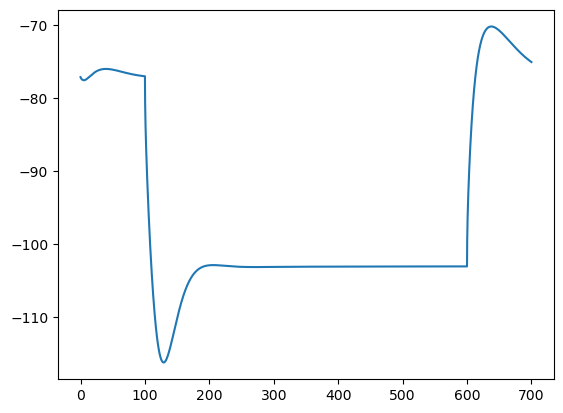

In [11]:
import matplotlib.pyplot as plt


def calculate_Rin_simulation(segments, v_init):
    soma_seg = segments[0]
    # Simulation for validation
    stim = h.IClamp(soma_seg)
    stim.delay = 100  # ms
    stim.dur = 500    # ms
    stim.amp = -1     # nA

    v = h.Vector().record(soma_seg._ref_v)
    t = h.Vector().record(h._ref_t)
    vs = []
    for i,seg in enumerate(segments):
        vs.append(h.Vector().record(seg._ref_v))


    h.finitialize(v_init)
    h.continuerun(700)

    v_rest = v[int(100 / h.dt)]
    v_steady = v[int(600 / h.dt)]
    v_rests = [v[int(100 / h.dt)] for v in vs]

    delta_v = v_steady - v_rest
    R_in_soma_simulation = delta_v / stim.amp  # in MOhms
    print(f"Soma v_rest (simulation): {v_rest} mV")
    print(f"Soma v_steady (simulation): {v_steady} mV")
    print(f"Soma input resistance (simulation): {R_in_soma_simulation} MOhms")

    return v,t, v_rests

v,t, vrests = calculate_Rin_simulation(segments, v_init=-77.15)
plt.plot(t,v)
plt.show()

Soma v_rest (simulation): -77.03115965556812 mV
Soma v_steady (simulation): -103.05528691801365 mV
Soma input resistance (simulation): 26.024127262445532 MOhms


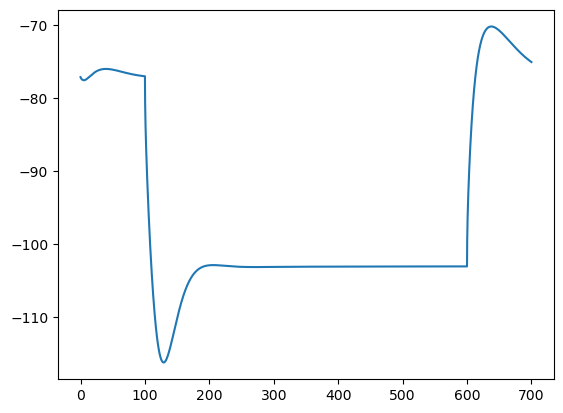

In [12]:
import matplotlib.pyplot as plt

# record resting gating variables and voltages
def calculate_Rin_simulation_record_resting(segments, v_init):
    soma_seg = segments[0]
    # Simulation for validation
    stim = h.IClamp(soma_seg)
    stim.delay = 100  # ms
    stim.dur = 500    # ms
    stim.amp = -1     # nA

    v = h.Vector().record(soma_seg._ref_v)
    t = h.Vector().record(h._ref_t)

    vs = []
    for i,seg in enumerate(segments):
        vs.append(h.Vector().record(seg._ref_v))

    gating_variables = [{} for _ in segments]
    for seg, gating_dict in zip(segments, gating_variables):
        for mech in seg:
            for var in dir(mech):
                if var in ['m', 'h', 'n']:  # Include other gating variables as needed
                    gating_dict[var] = h.Vector().record(getattr(mech, f'_ref_{var}'))

    h.finitialize(v_init)
    h.continuerun(700)

    v_rest = v[int(100 / h.dt)]
    v_steady = v[int(600 / h.dt)]
    v_rests = [v[int(100 / h.dt)] for v in vs]
    steady_state_gating = []
    for gating_dict in gating_variables:
        steady_state_values = {}
        for var, vec in gating_dict.items():
            steady_state_values[var] = vec[int(100 / h.dt)]  # Use the value at the same time as vrests
        steady_state_gating.append(steady_state_values)

    delta_v = v_steady - v_rest
    R_in_soma_simulation = delta_v / stim.amp  # in MOhms
    print(f"Soma v_rest (simulation): {v_rest} mV")
    print(f"Soma v_steady (simulation): {v_steady} mV")
    print(f"Soma input resistance (simulation): {R_in_soma_simulation} MOhms")

    return v,t, v_rests, steady_state_gating

v,t, vrests, steady_state_gating = calculate_Rin_simulation_record_resting(segments, v_init=-77.15)
plt.plot(t,v)
plt.show()

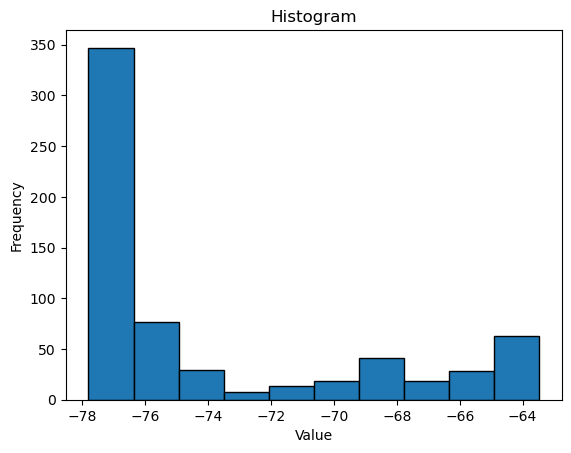

In [13]:
plt.hist(vrests, bins=10, edgecolor='black')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Trying to improve analytical accuracy by updating v_init to equal v_rest.

In [33]:
def set_gating_variables_from_steady_state(segments, steady_state_gating):
    """
    Set the gating variables for each segment to their steady-state values.
    
    Parameters:
    segments (list): List of segments in the model.
    steady_state_gating (list of dicts): List of dictionaries containing the steady-state gating variables
                                         for each segment.
    """
    for seg, gating_values in zip(segments, steady_state_gating):
        for mech in seg:
            for var, value in gating_values.items():
                if hasattr(mech, var):
                    setattr(mech, var, value)

def calculate_soma_input_resistance_all_segs_vrests(segments, vrests, steady_state_gating, active_channels=1):
    # Ensure segments and vrests lists are of the same length
    assert len(segments) == len(vrests), "Segments and vrests lists must be of the same length"
    
    # Set the initial membrane potential for each segment
    for seg, vrest in zip(segments, vrests):
        seg.v = vrest  # Set the membrane potential of each segment directly

    set_gating_variables_from_steady_state(segments, steady_state_gating)  # Initialize active channel states
    
    # Initialize NEURON's Impedance class
    impedance = h.Impedance()
    
    # Define the frequency for impedance calculation (0 Hz for input resistance)
    frequency = 0
    
    # Set up the impedance calculation, reference to the first compartment (soma)
    soma_seg = segments[0]
    impedance.loc(soma_seg)  # Assume the soma is at the center
    
    # Perform the extended impedance calculation
    impedance.compute(frequency, active_channels)
    
    # Get the input resistance at the soma
    R_in_soma = impedance.input(soma_seg)
    
    return R_in_soma

R_in_soma = calculate_soma_input_resistance_all_segs_vrests(segments, vrests, steady_state_gating)
print(f"Soma input resistance: {R_in_soma} MOhms")

Soma input resistance: 23.7910609084026 MOhms


run simulation again after update initial values

Soma v_rest (simulation): -77.03115965556812 mV
Soma v_steady (simulation): -103.05528691801365 mV
Soma input resistance (simulation): 26.024127262445532 MOhms


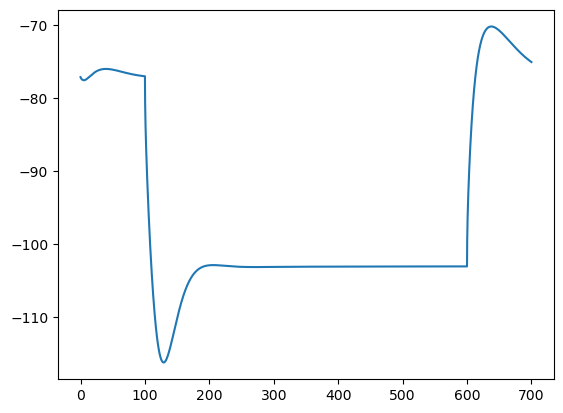

In [25]:
def calculate_Rin_simulation(segments, v_init):
    soma_seg = segments[0]
    # Simulation for validation
    stim = h.IClamp(soma_seg)
    stim.delay = 100  # ms
    stim.dur = 500    # ms
    stim.amp = -1     # nA

    v = h.Vector().record(soma_seg._ref_v)
    t = h.Vector().record(h._ref_t)
    vs = []
    for i,seg in enumerate(segments):
        vs.append(h.Vector().record(seg._ref_v))


    h.finitialize(v_init)
    h.continuerun(700)

    v_rest = v[int(100 / h.dt)]
    v_steady = v[int(600 / h.dt)]
    v_rests = [v[int(100 / h.dt)] for v in vs]

    delta_v = v_steady - v_rest
    R_in_soma_simulation = delta_v / stim.amp  # in MOhms
    print(f"Soma v_rest (simulation): {v_rest} mV")
    print(f"Soma v_steady (simulation): {v_steady} mV")
    print(f"Soma input resistance (simulation): {R_in_soma_simulation} MOhms")

    return v,t, v_rests

v,t, vrests = calculate_Rin_simulation(segments, v_init=-77.15)
plt.plot(t,v)
plt.show()

In summary, the analytical approach can be a good approximation if the resting state variables and voltages are known. Unfortunately simulation was used to know them.

In [27]:
# soma_mechs = [mech for mech in soma_seg]

In [30]:
# soma_mechs[4].m

0.002121616948244206

In [18]:
# for mech in soma_seg:
#     print(mech)

Ih
ca_ion
CaDynamics_E2
na_ion
NaTa_t
Nap_Et2
k_ion
K_Pst
K_Tst
SK_E2
SKv3_1
Ca_HVA
Ca_LVAst
pas


Notes:
1. analytical soma_Rin calculation = 40.56 MOhms.
2. simulated soma_Rin = 26.02 MOhms
3. analytical soma_Rin without including active gating variables = 58.52 mV
4. analytical soma_Rin calculation treats v_init as v_rest.
5. Simulated v_rest is -77.15 mV
6. Soma e_pas is -90 mV

In [31]:
# impedance.input(soma_seg)

40.496350629720645

In [34]:
# dir(h)